# Arboles de Clasificacion y Regresion 

In [20]:
from sklearn.datasets import load_iris
from sklearn import tree

from sklearn.model_selection import train_test_split

iris = load_iris()

X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.3, random_state=0)

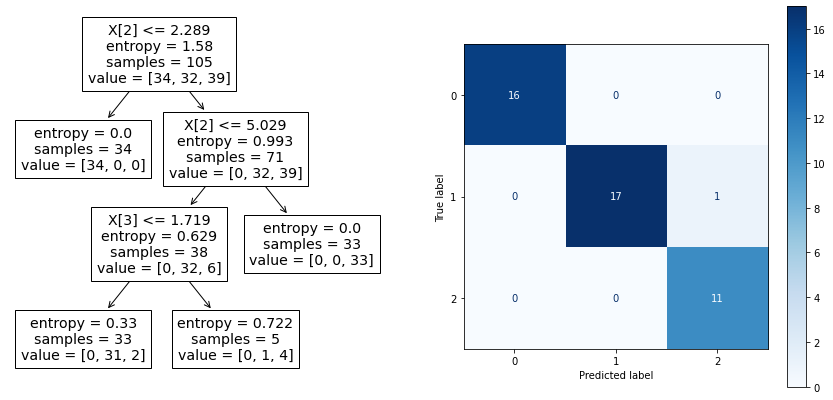

In [48]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,plot_confusion_matrix,roc_auc_score

clf = tree.DecisionTreeClassifier(random_state=0,criterion='entropy',splitter='random',max_depth=3)

clf = clf.fit(X_train, y_train)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,7))
tree.plot_tree(clf,ax=ax1)
plot_confusion_matrix(clf, X_test, y_test,cmap=plt.cm.Blues,ax=ax2)
plt.show()

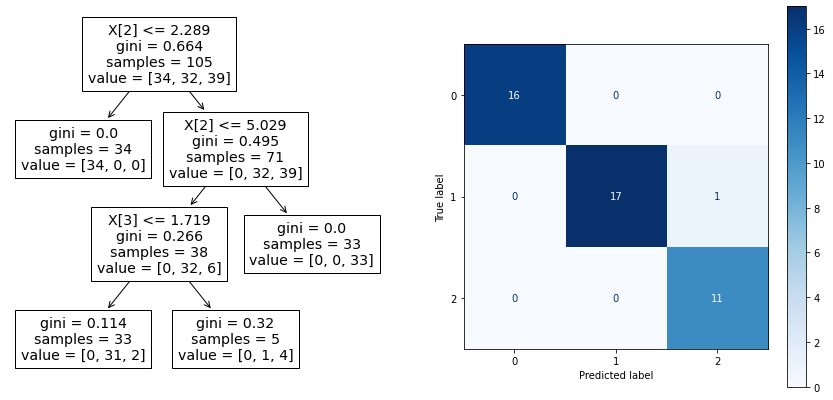

In [50]:
clf = tree.DecisionTreeClassifier(random_state=0,criterion='gini',splitter='random',max_depth=3)
iris = load_iris()

clf = clf.fit(X_train,y_train)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,7))
tree.plot_tree(clf,ax=ax1)
plot_confusion_matrix(clf, X_test, y_test,cmap=plt.cm.Blues,ax=ax2)
plt.show()

# Tarea

En este laboratorio Ud debe completar las siguientes tareas:


1.   Implementar un modelo de arbol para predecir la supervivencia de un paciente infectado con COVID usando datos epidemiologicos (Datos obtenidos desde [1]).
2. Reportar la metrica de ajuste del modelo base.
3. Reportar la metrica de ajuste del modelo usando ensambles.

[1] https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7306186/#!po=54.1667

In [51]:
import pandas as pd

patient_info=pd.read_csv('https://raw.githubusercontent.com/sherna90/mineria_datos/master/data/datasets_527325_1332417_PatientInfo.csv')
#patient_info=pd.read_csv('data/datasets_527325_1332417_PatientInfo.csv')

In [52]:
patient_info['confirmed_date']=pd.to_datetime(patient_info['confirmed_date'],format='%Y/%m/%d')
patient_info['released_date']=pd.to_datetime(patient_info['released_date'],format='%Y/%m/%d')
patient_info['deceased_date']=pd.to_datetime(patient_info['deceased_date'],format='%Y/%m/%d')

patient_info['sex'] = patient_info['sex'].astype('category')
patient_info['age'] = patient_info['age'].astype('category')
patient_info['infection_case'] = patient_info['infection_case'].astype('category')

In [53]:
patient_info.drop(columns=['country','province','city','infected_by','contact_number','symptom_onset_date'],inplace=True)

In [54]:
patient_info['state'] = patient_info['state'].astype('category')

In [55]:
data=patient_info.loc[(patient_info['state']=='released') | (patient_info['state']=='deceased')]

In [58]:
data.head()

,patient_id,sex,age,infection_case,confirmed_date,released_date,deceased_date,state
0,1000000001,male,50s,overseas inflow,2020-01-23,2020-02-05,NaT,released
1,1000000002,male,30s,overseas inflow,2020-01-30,2020-03-02,NaT,released
2,1000000003,male,50s,contact with patient,2020-01-30,2020-02-19,NaT,released
3,1000000004,male,20s,overseas inflow,2020-01-30,2020-02-15,NaT,released
4,1000000005,female,20s,contact with patient,2020-01-31,2020-02-24,NaT,released


In [63]:
data.shape

(3007, 8)

In [59]:
days_released=data.loc[data['state']=='released']['released_date']-data.loc[data['state']=='released']['confirmed_date']

In [62]:
days_deceased=data.loc[data['state']=='deceased']['deceased_date']-data.loc[data['state']=='deceased']['confirmed_date']

In [81]:
df_days=data.join(days_deceased.fillna(method='bfill').fillna(method='ffill').rename('no_days'))

In [82]:
df_days.loc[df_days.state=='released','no_days']=days_released.copy()

In [83]:
df_days.drop(columns=['confirmed_date','released_date','deceased_date'],inplace=True)

In [84]:
s=df_days.loc[df_days.state=='released',:].isna().any(axis=1)
index_nan=[i for i in s.index if s[i]]

In [85]:
df_days.drop(index_nan,inplace=True)

In [86]:
df_days.shape

(1075, 6)

In [87]:
df_days.loc[df_days.state=='released',:].isna().sum()

patient_id        0
sex               0
age               0
infection_case    0
state             0
no_days           0
dtype: int64

In [88]:
df_days.loc[df_days.state=='deceased',:].isna().sum()

patient_id         0
sex                3
age                3
infection_case    42
state              0
no_days            0
dtype: int64

In [89]:
df_days.loc[df_days.state=='deceased',:]

,patient_id,sex,age,infection_case,state,no_days
12,1000000013,male,80s,contact with patient,deceased,5 days
108,1000000109,male,90s,contact with patient,deceased,5 days
284,1000000285,male,40s,Guro-gu Call Center,deceased,5 days
472,1000000473,male,60s,contact with patient,deceased,5 days
996,1000000997,NaN,NaN,NaN,deceased,5 days
...,...,...,...,...,...,...
4903,6020100107,male,60s,Cheongdo Daenam Hospital,deceased,3 days
4904,6020100205,female,50s,Cheongdo Daenam Hospital,deceased,-1 days
4905,6020100286,male,60s,Cheongdo Daenam Hospital,deceased,1 days
4906,6020100298,male,50s,Cheongdo Daenam Hospital,deceased,3 days


In [90]:
df_days.fillna(method='ffill',inplace=True)

In [74]:
#df_days.drop(columns=['infection_case'],inplace=True)

In [91]:
df_days.loc[df_days.state=='deceased',:].isna().sum()

patient_id        0
sex               0
age               0
infection_case    0
state             0
no_days           0
dtype: int64

In [76]:
df_days.fillna(method='ffill',inplace=True)

# Arbol de Clasificacion

In [155]:
from sklearn.model_selection import train_test_split

X=df_days[['sex','age','infection_case']]
X=pd.get_dummies(X)
X['no_days'] = df_days['no_days'].dt.days.copy()
y=df_days['state']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [113]:
X.shape

(1075, 65)

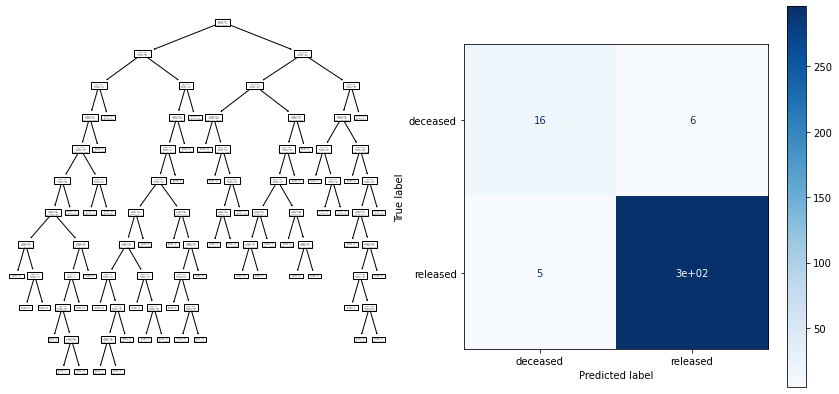

In [161]:
clf = tree.DecisionTreeClassifier(criterion='entropy',splitter='best',class_weight='balanced')

clf = clf.fit(X_train, y_train)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,7))
tree.plot_tree(clf,ax=ax1)
plot_confusion_matrix(clf, X_test, y_test,cmap=plt.cm.Blues,ax=ax2)
plt.show()

In [162]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

y_pred=clf.predict(X_test)

print(classification_report(y_test, y_pred))
print('Accuracy : {}'.format(accuracy_score(y_test,y_pred)))

              precision    recall  f1-score   support

    deceased       0.76      0.73      0.74        22
    released       0.98      0.98      0.98       301

    accuracy                           0.97       323
   macro avg       0.87      0.86      0.86       323
weighted avg       0.97      0.97      0.97       323

Accuracy : 0.9659442724458205


In [189]:
from sklearn import ensemble
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

def gradient_boosting(n,l,d):
  clf = ensemble.GradientBoostingClassifier(max_depth=d,learning_rate=l,n_estimators=n,max_features='auto')
  clf = clf.fit(X_train, y_train)
  y_pred=clf.predict(X_test)
  #print(classification_report(y_test, y_pred))
  return confusion_matrix(y_test,y_pred)[0,0]/np.sum(y_test=='deceased')

In [190]:
n_estimators=[100,300,500]
learning_rate=[0.1,0.01]
max_depth=[2,3]

estimators_results=[]
lr_results=[]
depth_results=[]
accuracy_results=[]
for (n,l,d) in ((i, j,k) for i in n_estimators for  j in learning_rate for k in max_depth):
  #print('--------------------------------------------------------------------')
  #print('n estimators : {}, learning rate : {}, max depth : {}'.format(n,l,d))
  acc=gradient_boosting(n,l,d)
  estimators_results.append(n)
  lr_results.append(l)
  depth_results.append(d)
  accuracy_results.append(acc)

results=pd.DataFrame({'n_estimators':estimators_results,
                       'max_depth':depth_results,'learning_rate':lr_results,'accuracy_results':accuracy_results})

In [167]:
results.head()

,n_estimators,max_depth,learning_rate,accuracy_results
0,100,2,0.10,0.975232
1,100,3,0.10,0.972136
2,100,5,0.10,0.969040
3,100,10,0.10,0.956656
4,100,2,0.01,0.962848


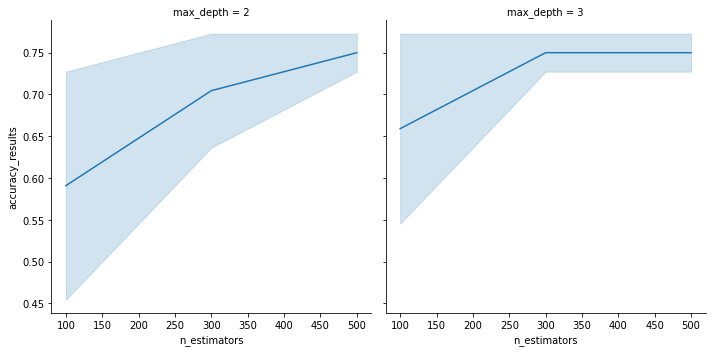

In [193]:
import seaborn as sns

sns.relplot(x="n_estimators", y="accuracy_results",
            col="max_depth",kind="line", legend="full",col_wrap=2, data=results)

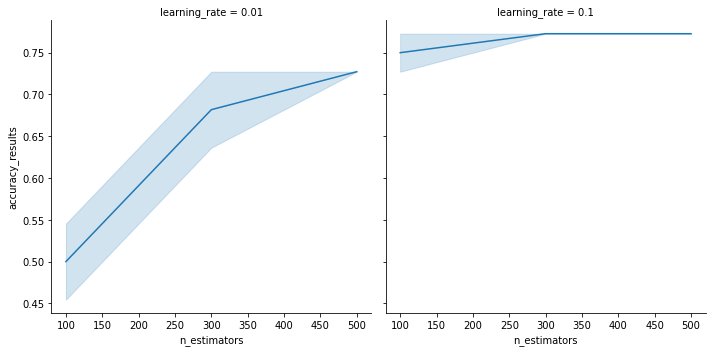

In [192]:
sns.relplot(x="n_estimators", y="accuracy_results",
            col="learning_rate",kind="line", legend="full",col_wrap=2, data=results)